In [1]:
import pandas as pd
import cv2
import time
from PIL import Image

In [2]:
import xml.etree.ElementTree as ET
import os

def parse_annotation(ann_dir, img_dir, labels=[]):
    all_imgs = []
    seen_labels = {}
    
    for ann in os.listdir(ann_dir):
        img = {'object':[]}

        tree = ET.parse(ann_dir + ann)
        
        for elem in tree.iter():
            if 'folder' in elem.tag:
                img['folder'] = img_dir + "images/" + elem.text
            if 'filename' in elem.tag:
                img['filename'] = img['folder'] + "/" + elem.text
            if 'width' in elem.tag:
                img['width'] = int(elem.text)
            if 'height' in elem.tag:
                img['height'] = int(elem.text)
            if 'object' in elem.tag or 'part' in elem.tag:
                obj = {}
                
                for attr in list(elem):
                    if 'name' in attr.tag:
                        obj['name'] = attr.text

                        if obj['name'] in seen_labels:
                            seen_labels[obj['name']] += 1
                        else:
                            seen_labels[obj['name']] = 1
                        
                        if len(labels) > 0 and obj['name'] not in labels:
                            break
                        else:
                            img['object'] += [obj]
                            
                    if 'bndbox' in attr.tag:
                        for dim in list(attr):
                            if 'xmin' in dim.tag:
                                obj['xmin'] = int(round(float(dim.text)))
                            if 'ymin' in dim.tag:
                                obj['ymin'] = int(round(float(dim.text)))
                            if 'xmax' in dim.tag:
                                obj['xmax'] = int(round(float(dim.text)))
                            if 'ymax' in dim.tag:
                                obj['ymax'] = int(round(float(dim.text)))

        if len(img['object']) > 0:
            all_imgs += [img]
                        
    return all_imgs, seen_labels

train_image_folder = 'wider_face/data/WIDER_train/'
train_annot_folder = 'wider_face/data/WIDER_train_annotations/'

train_imgs, train_labels = parse_annotation(train_annot_folder, train_image_folder, labels=['face'])

In [3]:
train_labels

{'face': 159424}

In [4]:
train_imgs

[{'object': [{'name': 'face',
    'xmin': 174,
    'ymin': 321,
    'xmax': 796,
    'ymax': 965}],
  'folder': 'wider_face/data/WIDER_train/images/28--Sports_Fan',
  'filename': 'wider_face/data/WIDER_train/images/28--Sports_Fan/28_Sports_Fan_Sports_Fan_28_216.jpg',
  'width': 1024,
  'height': 1392},
 {'object': [{'name': 'face',
    'xmin': 580,
    'ymin': 90,
    'xmax': 672,
    'ymax': 216},
   {'name': 'face', 'xmin': 714, 'ymin': 182, 'xmax': 818, 'ymax': 328}],
  'folder': 'wider_face/data/WIDER_train/images/20--Family_Group',
  'filename': 'wider_face/data/WIDER_train/images/20--Family_Group/20_Family_Group_Family_Group_20_383.jpg',
  'width': 1024,
  'height': 683},
 {'object': [{'name': 'face',
    'xmin': 574,
    'ymin': 292,
    'xmax': 630,
    'ymax': 346}],
  'folder': 'wider_face/data/WIDER_train/images/7--Cheering',
  'filename': 'wider_face/data/WIDER_train/images/7--Cheering/7_Cheering_Cheering_7_611.jpg',
  'width': 1024,
  'height': 767},
 {'object': [{'name': 

In [5]:
"wider_face/data/WIDER_train/28--Sports_Fan28_Sports_Fan_Sports_Fan_28_216.jpg"

'wider_face/data/WIDER_train/28--Sports_Fan28_Sports_Fan_Sports_Fan_28_216.jpg'

In [6]:
train_imgs

[{'object': [{'name': 'face',
    'xmin': 174,
    'ymin': 321,
    'xmax': 796,
    'ymax': 965}],
  'folder': 'wider_face/data/WIDER_train/images/28--Sports_Fan',
  'filename': 'wider_face/data/WIDER_train/images/28--Sports_Fan/28_Sports_Fan_Sports_Fan_28_216.jpg',
  'width': 1024,
  'height': 1392},
 {'object': [{'name': 'face',
    'xmin': 580,
    'ymin': 90,
    'xmax': 672,
    'ymax': 216},
   {'name': 'face', 'xmin': 714, 'ymin': 182, 'xmax': 818, 'ymax': 328}],
  'folder': 'wider_face/data/WIDER_train/images/20--Family_Group',
  'filename': 'wider_face/data/WIDER_train/images/20--Family_Group/20_Family_Group_Family_Group_20_383.jpg',
  'width': 1024,
  'height': 683},
 {'object': [{'name': 'face',
    'xmin': 574,
    'ymin': 292,
    'xmax': 630,
    'ymax': 346}],
  'folder': 'wider_face/data/WIDER_train/images/7--Cheering',
  'filename': 'wider_face/data/WIDER_train/images/7--Cheering/7_Cheering_Cheering_7_611.jpg',
  'width': 1024,
  'height': 767},
 {'object': [{'name': 

In [7]:
import cv2
import numpy as np
from sklearn.model_selection import train_test_split
import tensorflow as tf

def load_labels(img_data):
    labels = []
    bboxes = []
    for img in img_data:
        obj = img['object'][0]  # Get the only object in the image
        xmin, ymin, xmax, ymax = obj['xmin'], obj['ymin'], obj['xmax'], obj['ymax']
        
        # Resize bounding box coordinates
        xmin_resized = int(xmin * 224 / img['width'])
        ymin_resized = int(ymin * 224 / img['height'])
        xmax_resized = int(xmax * 224 / img['width'])
        ymax_resized = int(ymax * 224 / img['height'])
        
        labels.append([1])
        bboxes.append([xmin_resized, ymin_resized, xmax_resized, ymax_resized])
    
    labels = np.array(labels, dtype=np.uint8)
    bboxes = np.array(bboxes, dtype=np.float16)
    
    return labels, bboxes

# Split dataset into training and validation sets
train_imgs, val_imgs = train_test_split(train_imgs, test_size=0.2)

# Filter images with exactly one face
train_imgs_filtered = [img for img in train_imgs if len(img['object']) == 1]
val_imgs_filtered = [img for img in val_imgs if len(img['object']) == 1]

# Preprocess image data
X_train_images = np.array([cv2.resize(cv2.imread(img['filename']), (224, 224)) for img in train_imgs_filtered])
X_val_images = np.array([cv2.resize(cv2.imread(img['filename']), (224, 224)) for img in val_imgs_filtered])

# Load labels and bounding boxes
y_train_labels, y_train_bboxes = load_labels(train_imgs_filtered)
y_val_labels, y_val_bboxes = load_labels(val_imgs_filtered)


In [8]:
# Create TensorFlow datasets
train_labels_ds = tf.data.Dataset.from_tensor_slices((y_train_labels, y_train_bboxes))
val_labels_ds = tf.data.Dataset.from_tensor_slices((y_val_labels, y_val_bboxes))

train_images_ds = tf.data.Dataset.from_tensor_slices(X_train_images)
val_images_ds = tf.data.Dataset.from_tensor_slices(X_val_images)

# Zip the labels and images together
train = tf.data.Dataset.zip((train_images_ds, train_labels_ds))
val = tf.data.Dataset.zip((val_images_ds, val_labels_ds))

val = val.shuffle(5000)
train = train.shuffle(5000)

val = val.batch(8)
train = train.batch(8)

val = val.prefetch(4)
train = train.prefetch(4)


2024-04-20 14:26:01.001550: I metal_plugin/src/device/metal_device.cc:1154] Metal device set to: Apple M3 Pro
2024-04-20 14:26:01.001584: I metal_plugin/src/device/metal_device.cc:296] systemMemory: 18.00 GB
2024-04-20 14:26:01.001597: I metal_plugin/src/device/metal_device.cc:313] maxCacheSize: 6.00 GB
2024-04-20 14:26:01.001869: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:305] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2024-04-20 14:26:01.001880: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:271] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)


In [9]:
train.as_numpy_iterator().next()[1]

(array([[1],
        [1],
        [1],
        [1],
        [1],
        [1],
        [1],
        [1]], dtype=uint8),
 array([[106.,  22., 120.,  48.],
        [124.,  71., 160., 105.],
        [ 63.,  40., 115., 162.],
        [119.,  13., 196., 138.],
        [ 96.,  12., 125.,  50.],
        [ 93.,  37., 133.,  80.],
        [ 58.,  36.,  70.,  66.],
        [ 75.,  25.,  87.,  49.]], dtype=float16))

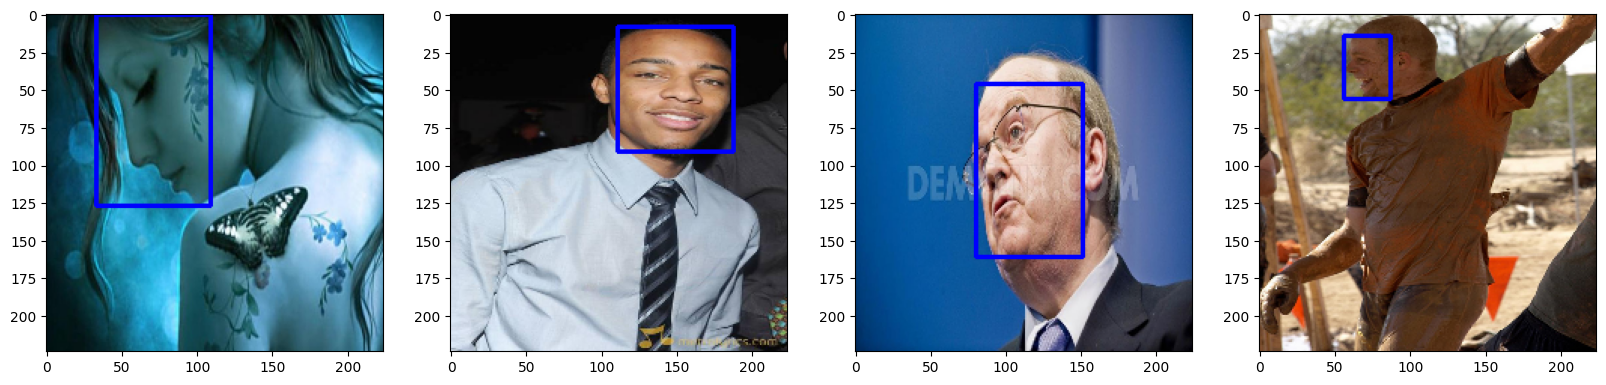

In [10]:
from matplotlib import pyplot as plt
import cv2

data_samples = train.as_numpy_iterator()
res = data_samples.next()

fig, ax = plt.subplots(ncols=4, figsize=(20,20))
for idx in range(4): 
    sample_image = res[0][idx].copy()
    sample_coords = res[1][1][idx]

    cv2.rectangle(sample_image, 
                  sample_coords[:2].astype(int),
                  sample_coords[2:].astype(int), 
                        (255,0,0), 2)
    
    sample_image = cv2.cvtColor(sample_image, cv2.COLOR_BGR2RGB)  # Convert color format
    
    ax[idx].imshow(sample_image)

In [11]:
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Conv2D, Dense, GlobalMaxPooling2D
from tensorflow.keras.applications import VGG16
import ssl
ssl._create_default_https_context = ssl._create_unverified_context

In [12]:
vgg = VGG16(include_top=False)

In [13]:
def build_model(): 
    input_layer = Input(shape=(224,224,3))
    
    vgg = VGG16(include_top=False)(input_layer)

    # Classification Model  
    f1 = GlobalMaxPooling2D()(vgg)
    class1 = Dense(2048, activation='relu')(f1)
    class2 = Dense(1, activation='sigmoid')(class1)
    
    # Bounding box model
    f2 = GlobalMaxPooling2D()(vgg)
    regress1 = Dense(2048, activation='relu')(f2)
    regress2 = Dense(4, activation='sigmoid')(regress1)
    
    facetracker = Model(inputs=input_layer, outputs=[class2, regress2])
    return facetracker

In [14]:
facetracker = build_model()

In [15]:
facetracker.summary()

Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_1       │ (None, 224, 224,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ vgg16 (Functional)  │ (None, 7, 7, 512) │ 14,714,688 │ input_layer_1[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ global_max_pooling… │ (None, 512)       │          0 │ vgg16[0][0]       │
│ (GlobalMaxPooling2… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ global_max_pooling… │ (None, 512)       │          0 │ vgg16[0][0]       │
│ (GlobalMaxPooling2… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense (Dense)       │ (None, 2048)      │  1,050,624 │ global_max_pooli… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_2 (Dense)     │ (None, 2048)      │  1,050,624 │ global_max_pooli… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_1 (Dense)     │ (None, 1)         │      2,049 │ dense[0][0]       │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_3 (Dense)     │ (None, 4)         │      8,196 │ dense_2[0][0]     │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 16,826,181 (64.19 MB)

 Trainable params: 16,826,181 (64.19 MB)

 Non-trainable params: 0 (0.00 B)

In [16]:
X, y = train.as_numpy_iterator().next()

In [17]:
X.shape


(8, 224, 224, 3)

In [18]:
classes, coords = facetracker.predict(X)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 206ms/step


2024-04-20 14:26:02.915110: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:117] Plugin optimizer for device_type GPU is enabled.


In [19]:
classes, coords


(array([[9.6051669e-01],
        [5.8282711e-02],
        [8.6075841e-10],
        [5.0605887e-01],
        [2.1474966e-12],
        [9.1603053e-01],
        [6.1741754e-19],
        [1.3226255e-05]], dtype=float32),
 array([[8.8184202e-01, 1.9288165e-14, 1.7331030e-04, 4.8483351e-09],
        [1.0000000e+00, 1.4981696e-02, 4.6681388e-14, 1.9285839e-07],
        [7.7247644e-12, 3.8903467e-21, 1.5145277e-08, 9.5743787e-01],
        [4.7793947e-02, 1.7243406e-13, 8.4679513e-13, 9.9999213e-01],
        [9.9925905e-01, 4.0227795e-12, 4.9625349e-04, 1.1310137e-03],
        [1.0000000e+00, 1.0000000e+00, 1.1823873e-19, 2.4209921e-09],
        [9.8320448e-01, 4.5758062e-14, 6.0760802e-01, 2.3117619e-13],
        [5.0936109e-01, 9.6487336e-15, 1.7431313e-03, 1.8605151e-15]],
       dtype=float32))

In [20]:
batches_per_epoch = len(train)
lr_decay = (1./0.75 -1)/batches_per_epoch


In [21]:
opt = tf.keras.optimizers.Adam(learning_rate=0.0001, decay=lr_decay)


/Users/arthurdesmazures/venv-metal/lib/python3.10/site-packages/keras/src/optimizers/base_optimizer.py:34: UserWarning: Argument `decay` is no longer supported and will be ignored.
  warnings.warn(


In [22]:
def localization_loss(y_true, yhat):            
    delta_coord = tf.reduce_sum(tf.square(y_true[:,:2] - yhat[:,:2]))
                  
    h_true = y_true[:,3] - y_true[:,1] 
    w_true = y_true[:,2] - y_true[:,0] 

    h_pred = yhat[:,3] - yhat[:,1] 
    w_pred = yhat[:,2] - yhat[:,0] 
    
    delta_size = tf.reduce_sum(tf.square(w_true - w_pred) + tf.square(h_true-h_pred))
    
    return delta_coord + delta_size


In [23]:
classloss = tf.keras.losses.BinaryCrossentropy()
regressloss = localization_loss


In [24]:
localization_loss(y[1], coords)


<tf.Tensor: shape=(), dtype=float32, numpy=173217.8>

In [25]:
classloss(y[0], classes)


<tf.Tensor: shape=(), dtype=float32, numpy=7.9048915>

In [26]:
regressloss(y[1], coords)


<tf.Tensor: shape=(), dtype=float32, numpy=173217.8>

In [27]:
class FaceTracker(Model): 
    def __init__(self, eyetracker,  **kwargs): 
        super().__init__(**kwargs)
        self.model = eyetracker

    def compile(self, opt, classloss, localizationloss, **kwargs):
        super().compile(**kwargs)
        self.closs = classloss
        self.lloss = localizationloss
        self.opt = opt
    
    def train_step(self, batch, **kwargs): 
        
        X, y = batch
        
        with tf.GradientTape() as tape: 
            classes, coords = self.model(X, training=True)
            
            batch_classloss = self.closs(y[0], classes)
            batch_localizationloss = self.lloss(tf.cast(y[1], tf.float32), coords)
            
            total_loss = batch_localizationloss+0.5*batch_classloss
            
            grad = tape.gradient(total_loss, self.model.trainable_variables)
        
        opt.apply_gradients(zip(grad, self.model.trainable_variables))
        
        return {"total_loss":total_loss, "class_loss":batch_classloss, "regress_loss":batch_localizationloss}
    
    def test_step(self, batch, **kwargs): 
        X, y = batch
        
        classes, coords = self.model(X, training=False)
        
        batch_classloss = self.closs(y[0], classes)
        batch_localizationloss = self.lloss(tf.cast(y[1], tf.float32), coords)
        total_loss = batch_localizationloss+0.5*batch_classloss
        
        return {"total_loss":total_loss, "class_loss":batch_classloss, "regress_loss":batch_localizationloss}
        
    def call(self, X, **kwargs): 
        return self.model(X, **kwargs)


In [28]:
model = FaceTracker(facetracker)


In [29]:
model.compile(opt, classloss, regressloss)


In [30]:
logdir='logs'


In [31]:
tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=logdir)


In [32]:
hist = model.fit(train, epochs=3, validation_data=val, callbacks=[tensorboard_callback])


Epoch 1/3
457/457 ━━━━━━━━━━━━━━━━━━━━ 115s 247ms/step - class_loss: 0.0240 - regress_loss: 155010.2656 - total_loss: 155010.2656 - loss: 0.0000e+00 - val_loss: 0.0000e+00
Epoch 2/3
457/457 ━━━━━━━━━━━━━━━━━━━━ 112s 245ms/step - class_loss: 0.0000e+00 - regress_loss: 155006.5312 - total_loss: 155006.5312 - loss: 0.0000e+00 - val_loss: 0.0000e+00
Epoch 3/3
457/457 ━━━━━━━━━━━━━━━━━━━━ 113s 247ms/step - class_loss: 0.0000e+00 - regress_loss: 155006.5312 - total_loss: 155006.5312 - loss: 0.0000e+00 - val_loss: 0.0000e+00


In [33]:
hist.history

{'loss': [0.0, 0.0, 0.0], 'val_loss': [0.0, 0.0, 0.0]}

KeyError: 'total_loss'

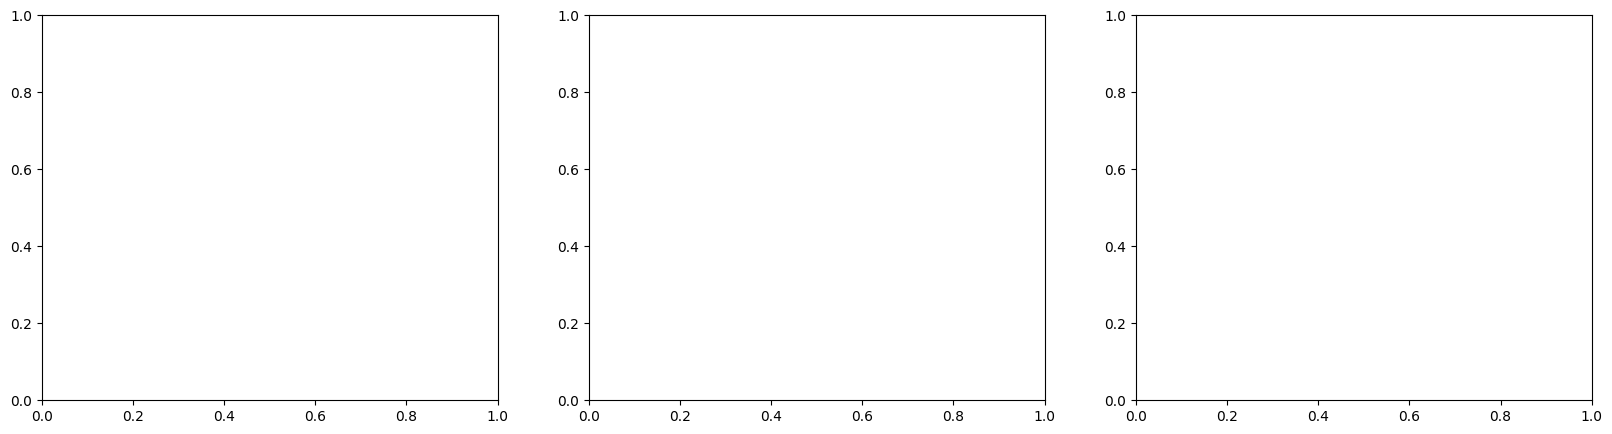

In [34]:
fig, ax = plt.subplots(ncols=3, figsize=(20,5))

ax[0].plot(hist.history['total_loss'], color='teal', label='loss')
ax[0].plot(hist.history['val_total_loss'], color='orange', label='val loss')
ax[0].title.set_text('Loss')
ax[0].legend()

ax[1].plot(hist.history['class_loss'], color='teal', label='class loss')
ax[1].plot(hist.history['val_class_loss'], color='orange', label='val class loss')
ax[1].title.set_text('Classification Loss')
ax[1].legend()

ax[2].plot(hist.history['regress_loss'], color='teal', label='regress loss')
ax[2].plot(hist.history['val_regress_loss'], color='orange', label='val regress loss')
ax[2].title.set_text('Regression Loss')
ax[2].legend()

plt.show()


In [ ]:
from tensorflow.keras.models import load_model

In [ ]:
facetracker.save('facetracker.h5')


ValueError: Unable to create dataset (name already exists)

In [ ]:
facetracker = load_model('facetracker.h5')


ValueError: The shape of the target variable and the shape of the target value in `variable.assign(value)` must match. variable.shape=(3, 3, 64, 64), Received: value.shape=(3, 3, 3, 64). Target variable: <KerasVariable shape=(3, 3, 64, 64), dtype=float32, path=block1_conv2/kernel>

In [ ]:
cap = cv2.VideoCapture(0)
while cap.isOpened():
    _ , frame = cap.read()
    frame = frame[50:500, 50:500,:]
    
    rgb = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
    resized = tf.image.resize(rgb, (120,120))
    
    yhat = facetracker.predict(np.expand_dims(resized/255,0))
    sample_coords = yhat[1][0]
    
    if yhat[0] > 0.5: 
        # Controls the main rectangle
        cv2.rectangle(frame, 
                      tuple(np.multiply(sample_coords[:2], [450,450]).astype(int)),
                      tuple(np.multiply(sample_coords[2:], [450,450]).astype(int)), 
                            (255,0,0), 2)
        # Controls the label rectangle
        cv2.rectangle(frame, 
                      tuple(np.add(np.multiply(sample_coords[:2], [450,450]).astype(int), 
                                    [0,-30])),
                      tuple(np.add(np.multiply(sample_coords[:2], [450,450]).astype(int),
                                    [80,0])), 
                            (255,0,0), -1)
        
        # Controls the text rendered
        cv2.putText(frame, 'face', tuple(np.add(np.multiply(sample_coords[:2], [450,450]).astype(int),
                                               [0,-5])),
                    cv2.FONT_HERSHEY_SIMPLEX, 1, (255,255,255), 2, cv2.LINE_AA)
    
    cv2.imshow('EyeTrack', frame)
    
    if cv2.waitKey(1) & 0xFF == ord('q'):
        break
cap.release()
cv2.destroyAllWindows()


ValueError: Input 0 of layer "functional_1" is incompatible with the layer: expected shape=(None, 224, 224, 3), found shape=(1, 120, 120, 3)